# 1. Importing and Setting Up the Environment

This section mounts Google Drive to Colab, checks the working directory (pwd), extracts the training dataset from a zip file, and installs the resampy library for audio processing.

## Mounting *Drive*

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Checking for working directory

In [3]:
!pwd

/content


## Unzip Train.zip

In [4]:
!unzip 'drive/MyDrive/Projects/train.zip'

Streaming output truncated to the last 5000 lines.
  inflating: Train/1674.wav          
  inflating: Train/1675.wav          
  inflating: Train/1677.wav          
  inflating: Train/1678.wav          
  inflating: Train/1679.wav          
  inflating: Train/168.wav           
  inflating: Train/1680.wav          
  inflating: Train/1681.wav          
  inflating: Train/1686.wav          
  inflating: Train/1687.wav          
  inflating: Train/1688.wav          
  inflating: Train/1689.wav          
  inflating: Train/1690.wav          
  inflating: Train/1695.wav          
  inflating: Train/1697.wav          
  inflating: Train/1699.wav          
  inflating: Train/17.wav            
  inflating: Train/170.wav           
  inflating: Train/1701.wav          
  inflating: Train/1702.wav          
  inflating: Train/1703.wav          
  inflating: Train/1704.wav          
  inflating: Train/1705.wav          
  inflating: Train/1706.wav          
  inflating: Train/1708.wav          

## Install resampy

In [5]:
!pip install resampy==0.2.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.4/323.4 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for resampy: filename=resampy-0.2.2-py3-none-any.whl size=320704 sha256=87f1d2e8940875b299cd551fa8dfa1db44863f8deed3126b142e57ee28845ae1
  Stored in directory: /root/.cache/pip/wheels/0f/df/63/a2209e98c9b8599049252b409794538bff2aa0d37b5e71fab6
Successfully built resampy


## Importing necessary libraries

Import the libraries for data handling (pandas, numpy), audio processing (librosa, IPython), visualization (matplotlib, seaborn), and environment management (os, warnings).

In [6]:
import pandas as pd
import numpy as np
import librosa
import resampy
import librosa.display
import glob
import IPython.display as ipd
import random
import seaborn as sns
import matplotlib.pyplot as plt
%pylab inline
import warnings
import os
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.11/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# 2. Loading and Exploring the Dataset


## Loading the data

In [7]:
df = pd.read_csv('/content/Urban Sound Dataset.csv')
df.head()

,ID,Class
0,0,siren
1,1,street_music
2,2,drilling
3,3,siren
4,4,dog_bark


## Checking for unique classes
The code checks for unique classes and missing values.

In [8]:
print('Number of unique classes :',df['Class'].nunique())
df['Class'].unique()

Number of unique classes : 10


array(['siren', 'street_music', 'drilling', 'dog_bark',
       'children_playing', 'gun_shot', 'engine_idling', 'air_conditioner',
       'jackhammer', 'car_horn'], dtype=object)

## Checking for null values

In [9]:
df.isnull().values.any()

False

## Visualizing Audio Files

A sample audio from Train dataset

In [10]:
ipd.Audio('Train/123.wav')

Below code loads an audio file, displays its waveform, and provides details about its data array and sampling rate.

Data : [-0.09316424 -0.14310586  0.05254411 ... -0.01574724 -0.0098122
  0.09794901]
Sampling Rate : 22050


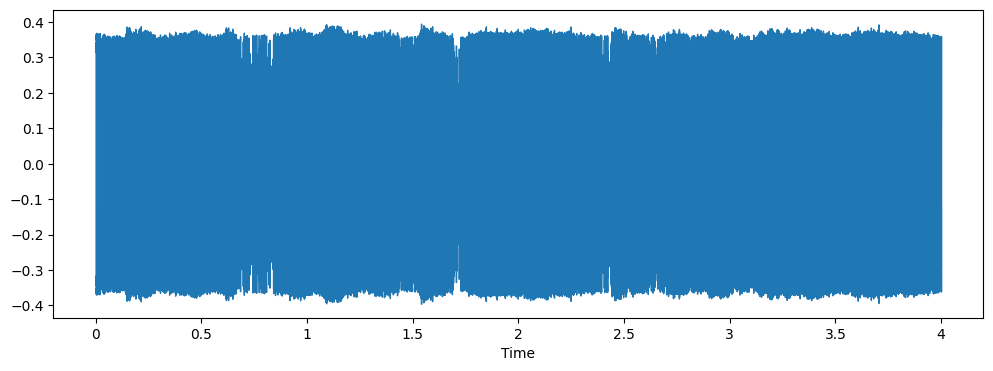

In [11]:
data, sampling_rate = librosa.load('Train/1.wav')

print("Data :",data)
print("Sampling Rate :",sampling_rate)

plt.figure(figsize=(12,4))
librosa.display.waveshow(data, sr=sampling_rate)

Some more examples are below

Class : dog_bark


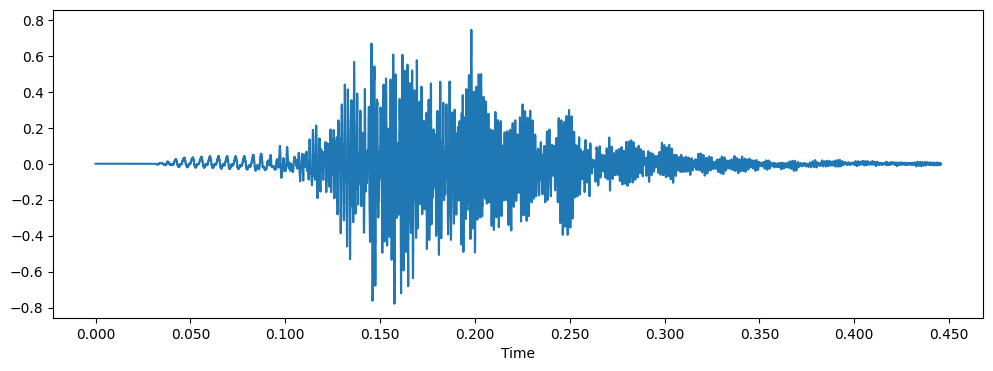

In [12]:
i = random.choice(df.index)
print('Class :', df['Class'][i])
data, sampling_rate = librosa.load('Train/'+str(df['ID'][i])+'.wav')
plt.figure(figsize=(12,4))
librosa.display.waveshow(data, sr=sampling_rate)

Class : engine_idling


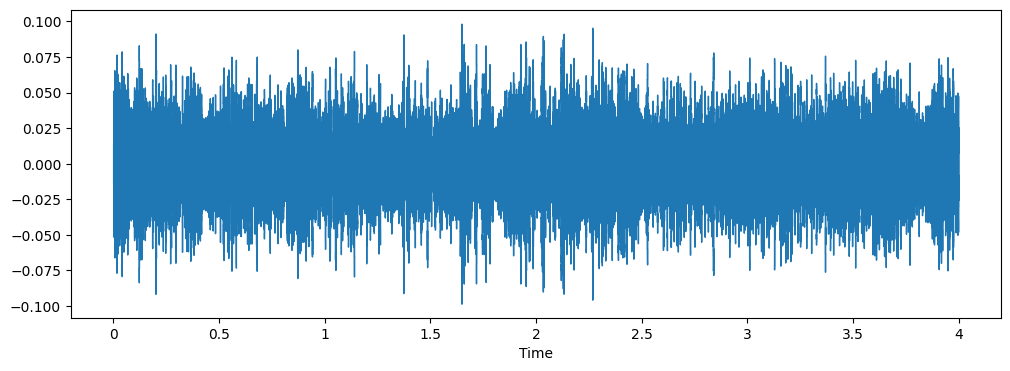

In [14]:
i = random.choice(df.index)
print('Class :', df['Class'][i])
data, sampling_rate = librosa.load('Train/'+str(df['ID'][i])+'.wav')
plt.figure(figsize=(12,4))
librosa.display.waveshow(data, sr=sampling_rate)

## Data Distribution

<Axes: xlabel='Class', ylabel='count'>

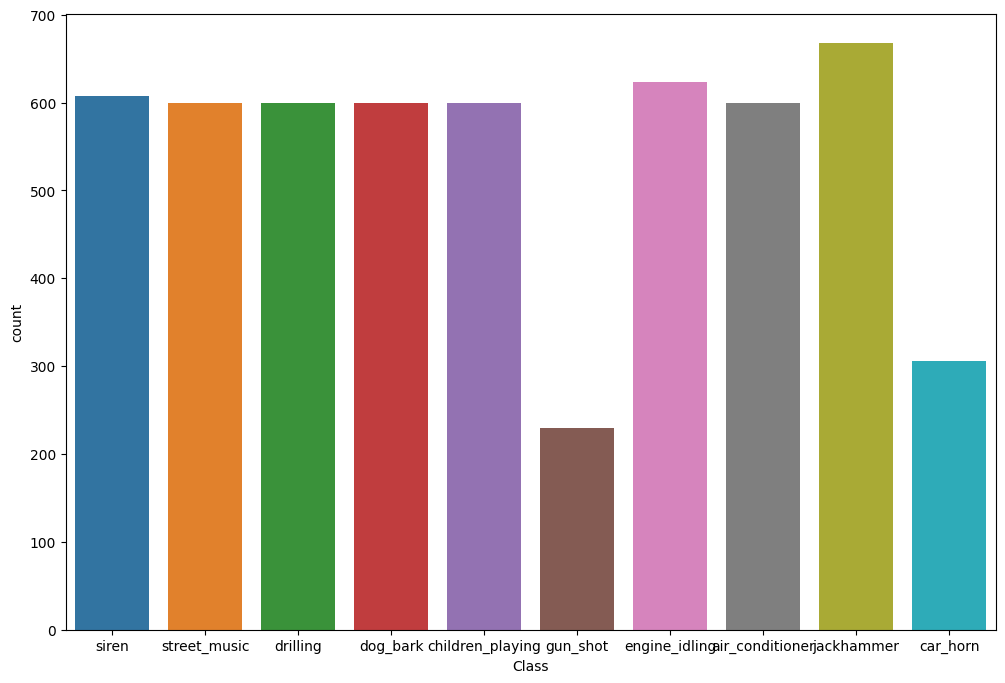

In [15]:
plt.figure(figsize=(12,8))
sns.countplot(hue='Class',data=df,x='Class')

# 3. Feature Extraction with MFCC

In [16]:
def parser(row):
  file_name = os.path.join('Train',str(row.ID)+'.wav')
  data, sampling_rate = librosa.load(file_name, res_type='kaiser_fast')
  mfccs = np.mean(librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=40).T,axis=0)
  feature = mfccs
  label = row.Class
  return [feature,label]

In [17]:
data = df.apply(parser,axis=1)
data = pd.DataFrame(data.tolist(), columns=['feature', 'label'])

In [18]:
data.iloc[0]

,0
feature,"[-82.44282, 139.54434, -42.461792, 24.845692, ..."
label,siren


# 4. Preparing Data for Training

In [19]:
X = np.array(data['feature'].tolist())
y = np.array(data['label'].tolist())

## Encoding the labels

In [20]:
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from keras.utils import to_categorical

le = LabelEncoder()
m = to_categorical(le.fit_transform(y))

In [21]:
m.shape

(5435, 10)

In [22]:
m[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])

# 5. Building the Neural Network

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam

num_classes = 10

model = Sequential()
model.add(Dense(256, input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │          10,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           5,130 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 10)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 147,210 (575.04 KB)

 Trainable params: 147,210 (575.04 KB)

 Non-trainable params: 0 (0.00 B)

# 6. Training the Model

In [24]:
model.fit(X,m, batch_size=32, epochs=100, validation_split=0.25)

Epoch 1/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.2389 - loss: 12.6165 - val_accuracy: 0.4805 - val_loss: 1.5705
Epoch 2/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4120 - loss: 2.1228 - val_accuracy: 0.5651 - val_loss: 1.4027
Epoch 3/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5014 - loss: 1.5377 - val_accuracy: 0.6233 - val_loss: 1.2118
Epoch 4/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5639 - loss: 1.3203 - val_accuracy: 0.6851 - val_loss: 1.0601
Epoch 5/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6052 - loss: 1.1472 - val_accuracy: 0.7241 - val_loss: 0.9556
Epoch 6/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6600 - loss: 0.9963 - val_accuracy: 0.7476 - val_loss: 0.8545
Epoch 7/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6961 - loss: 0.9047 - val_accuracy: 0.7528 - val_loss: 0.8068
Epoch 8/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6962 - loss: 0.8768 - val

# 7. Testing with new data

## Unzip Test.zip

In [25]:
!unzip 'drive/MyDrive/Projects/test.zip'

Archive:  drive/MyDrive/Projects/test.zip
   creating: Test/
  inflating: test.csv                
  inflating: Test/1002.wav           
  inflating: Test/1005.wav           
  inflating: Test/1009.wav           
  inflating: Test/1010.wav           
  inflating: Test/1011.wav           
  inflating: Test/1012.wav           
  inflating: Test/1013.wav           
  inflating: Test/1016.wav           
  inflating: Test/1019.wav           
  inflating: Test/102.wav            
  inflating: Test/1020.wav           
  inflating: Test/1023.wav           
  inflating: Test/1031.wav           
  inflating: Test/1033.wav           
  inflating: Test/1035.wav           
  inflating: Test/1037.wav           
  inflating: Test/1039.wav           
  inflating: Test/1041.wav           
  inflating: Test/1046.wav           
  inflating: Test/1050.wav           
  inflating: Test/1053.wav           
  inflating: Test/1057.wav           
  inflating: Test/106.wav            
  inflating: Test/1060.wav 

## Prediction

In [33]:
new_audio_file = "Test/988.wav"

In [34]:
def extract_mfcc(file_path):
    data, sampling_rate = librosa.load(file_path, res_type='kaiser_fast', duration=3)
    mfccs = np.mean(librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=40).T, axis=0)
    return mfccs

def predict_class(file_path, model):
    mfcc_features = extract_mfcc(file_path)
    mfcc_features = np.reshape(mfcc_features, (1, 40))
    predictions = model.predict(mfcc_features)
    predicted_class_idx = np.argmax(predictions)

    return predicted_class_idx

predicted_class_idx = predict_class(new_audio_file, model)
le = LabelEncoder()
le.fit(y)

predicted_class_label = le.inverse_transform([predicted_class_idx])[0]  # Decode the class index
print(f"The predicted class for the audio file is: {predicted_class_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
The predicted class for the audio file is: engine_idling


In [35]:
ipd.Audio(new_audio_file)